In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification-v2/Garbage Classification'

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (120, 120, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk


Shape of X_train, y_train: (15827, 120, 120, 3) (15827, 10)
Shape of X_test, y_test: (4397, 120, 120, 3) (4397, 10)
Shape of X_val, y_val: (1759, 120, 120, 3) (1759, 10)


In [3]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = GlobalAveragePooling2D()(input)
    se = Dense(filters // se_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [4]:
import tensorflow as tf
from keras.layers import Input, Dense,UpSampling2D,AveragePooling2D, Activation, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten, concatenate

from keras.layers import concatenate, multiply
from keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201

def create_parallel_cnn_model(input_shape, num_classes):
    MainInput = Input(shape=input_shape)
    dn169 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None)(MainInput)

    def squeeze_excite_block(input, filters, se_ratio):
        se = tf.keras.layers.GlobalAveragePooling2D()(input)  # Global Average Pooling along spatial dimensions
        se = tf.keras.layers.Reshape((1, 1, filters))(se)
        se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
        x = tf.keras.layers.multiply([input, se])
        return x
    # Branch with MaxPooling and Squeeze-Excitation
    conv1 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(strides=(2, 2), padding="same")(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)
    conv1 = squeeze_excite_block(conv1, 256, 16)  # Using 16 as the SE ratio

    # Branch with AveragePooling and Squeeze-Excitation
    conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = squeeze_excite_block(conv2, 256, 16)  # Using 16 as the SE ratio

    # Global Average Pooling to reduce spatial dimensions to (1, 1)
    conv1 = tf.keras.layers.GlobalAveragePooling2D()(conv1)
    conv2 = tf.keras.layers.GlobalAveragePooling2D()(conv2)

    # Concatenate both branches
    merged = concatenate([conv1, conv2])
    # Concatenate both branches
    merged = concatenate([conv1, conv2])

    # Dense layers
    dense1 = Dense(1024, activation="relu")(merged)
    dense2 = Dense(512, activation="relu")(dense1)
    output = Dense(num_classes, activation="softmax")(dense2)

    # Create the model
    model = Model(inputs=MainInput, outputs=output)

    return model




# Create the model
num_classes = y_train.shape[1]
model = create_parallel_cnn_model(target_shape, num_classes)
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])


74836368/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 3, 3, 1920)   18321984    ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 3, 3, 128)    12042368    ['densenet201[0][0]']            
                                                                                                  
 conv2d_4 (Conv2D)           

In [5]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                          epochs=40,
                          batch_size=10,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

Epoch 1/40
1583/1583 [==============================] - 211s 114ms/step - loss: 0.7065 - accuracy: 0.7723 - val_loss: 0.3276 - val_accuracy: 0.8931
Epoch 2/40
1583/1583 [==============================] - 169s 107ms/step - loss: 0.3473 - accuracy: 0.8882 - val_loss: 0.2617 - val_accuracy: 0.9130
Epoch 3/40
1583/1583 [==============================] - 166s 105ms/step - loss: 0.2287 - accuracy: 0.9245 - val_loss: 0.3531 - val_accuracy: 0.9016
Epoch 4/40
1583/1583 [==============================] - 168s 106ms/step - loss: 0.1706 - accuracy: 0.9445 - val_loss: 0.2367 - val_accuracy: 0.9312
Epoch 5/40
1583/1583 [==============================] - 169s 107ms/step - loss: 0.1139 - accuracy: 0.9639 - val_loss: 0.2339 - val_accuracy: 0.9369
Epoch 6/40
1583/1583 [==============================] - 167s 106ms/step - loss: 0.0955 - accuracy: 0.9704 - val_loss: 0.2695 - val_accuracy: 0.9323
Epoch 7/40
1583/1583 [==============================] - 168s 106ms/step - loss: 0.0765 - accuracy: 0.9758 - val_

Number of epochs trained: 37


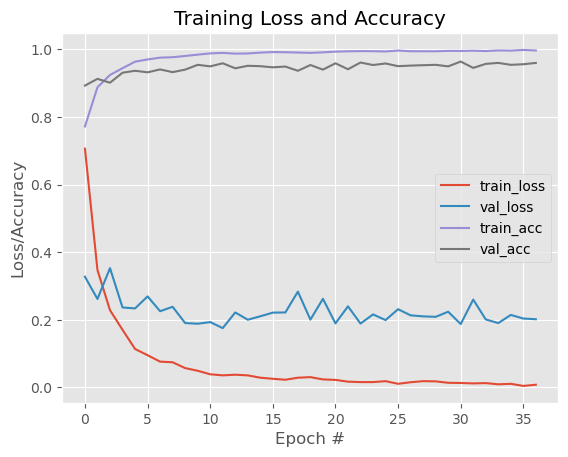

In [6]:
# Load the best weights
model.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("parallelCNN_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

In [7]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.14744937419891357
Test accuracy: 0.9636115431785583


In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

report = classification_report(y_test_labels, y_pred)
print(report)

138/138 [==============================] - 12s 59ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       346
           1       0.97      0.95      0.96       792
           2       0.98      0.97      0.98       235
           3       0.95      0.96      0.96       421
           4       0.97      0.96      0.96       185
           5       0.95      0.97      0.96       132
           6       0.97      0.95      0.96       389
           7       0.95      0.98      0.97       387
           8       1.00      0.98      0.99      1065
           9       0.93      0.93      0.93       445

    accuracy                           0.96      4397
   macro avg       0.96      0.96      0.96      4397
weighted avg       0.96      0.96      0.96      4397



Number of epochs trained: 37


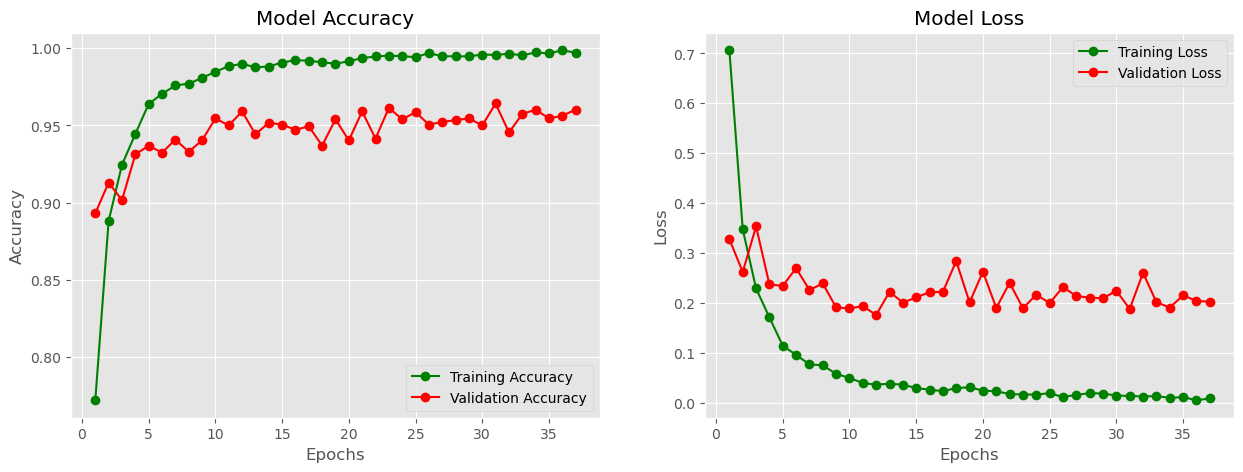

In [14]:
# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# History plotting
epochs = range(1, num_epochs_trained + 1)
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

# Save the figure as a PDF
plt.savefig('training_plot.pdf', format='pdf')

# Show the plot
plt.show()


138/138 [==============================] - 8s 59ms/step


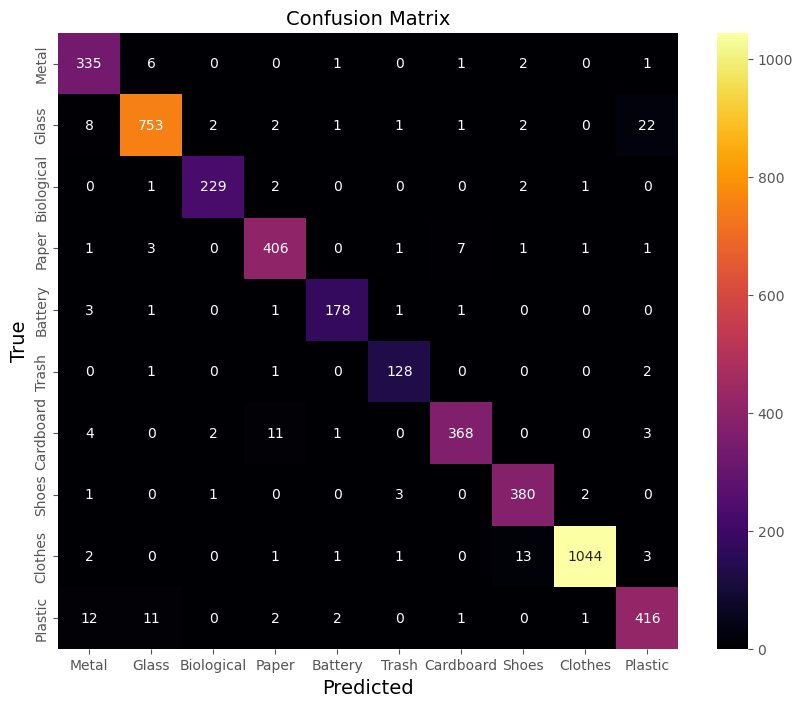

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ...

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
class_labels = ['Metal', 'Glass', 'Biological', 'Paper', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno',xticklabels=class_labels, yticklabels=class_labels)

# Customize the font properties for labels and title
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
plt.xlabel('Predicted', **title_font)
plt.ylabel('True', **title_font)
plt.title('Confusion Matrix', **title_font)

# Save the confusion matrix plot as a PDF file
plt.savefig('confusion_matrix.pdf', format='pdf')

# Show the plot
plt.show()


138/138 [==============================] - 8s 59ms/step


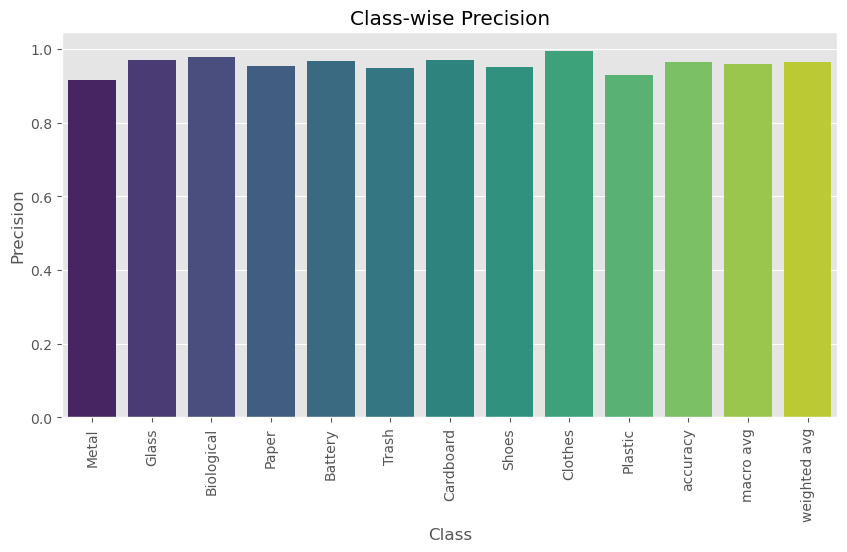

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
class_labels = ['Metal', 'Glass', 'Biological', 'Paper', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic']

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
class_report_df = pd.DataFrame(class_report).transpose()

# Plot class-wise precision
plt.figure(figsize=(10, 5))
sns.barplot(x=class_report_df.index, y=class_report_df['precision'], palette='viridis')
plt.title('Class-wise Precision')
plt.ylabel('Precision')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate the x-axis labels

# Save the figure as a PDF
plt.savefig('classwise_precision_plot.pdf', format='pdf')

plt.show()



138/138 [==============================] - 8s 59ms/step


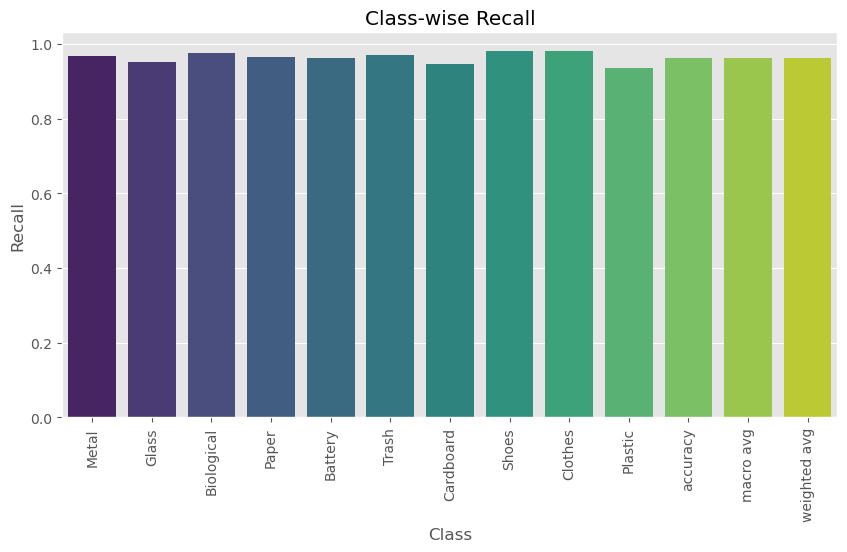

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
class_labels = ['Metal', 'Glass', 'Biological', 'Paper', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic']

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
class_report_df = pd.DataFrame(class_report).transpose()

# Plot class-wise recall
plt.figure(figsize=(10, 5))
sns.barplot(x=class_report_df.index, y=class_report_df['recall'], palette='viridis')
plt.title('Class-wise Recall')
plt.ylabel('Recall')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate the x-axis labels

# Save the figure as a PDF
plt.savefig('classwise_recall_plot.pdf', format='pdf')

plt.show()


138/138 [==============================] - 8s 59ms/step


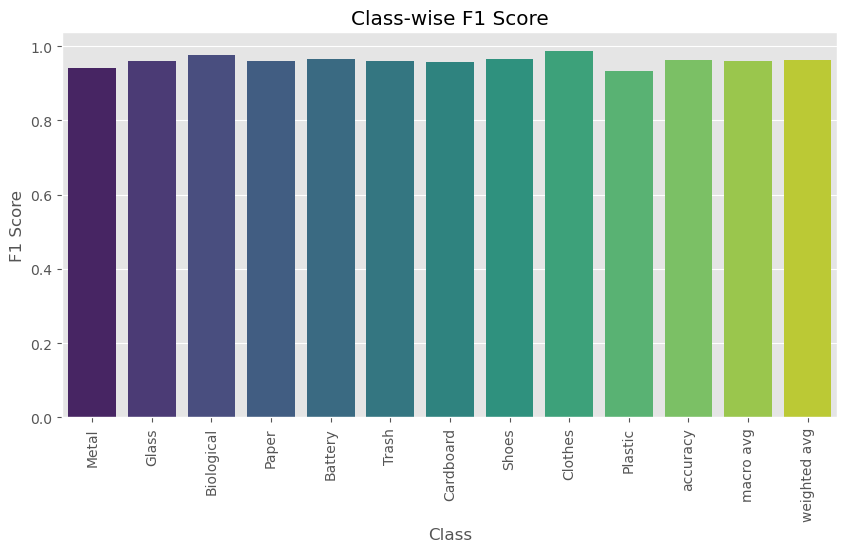

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
class_labels = ['Metal', 'Glass', 'Biological', 'Paper', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic']

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
class_report_df = pd.DataFrame(class_report).transpose()

# Plot class-wise F1 score with a different color
plt.figure(figsize=(10, 5))
sns.barplot(x=class_report_df.index, y=class_report_df['f1-score'], palette='viridis')
plt.title('Class-wise F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate the x-axis labels

# Save the figure as a PDF
plt.savefig('classwise_f1_score_plot.pdf', format='pdf')

plt.show()


138/138 [==============================] - 8s 59ms/step


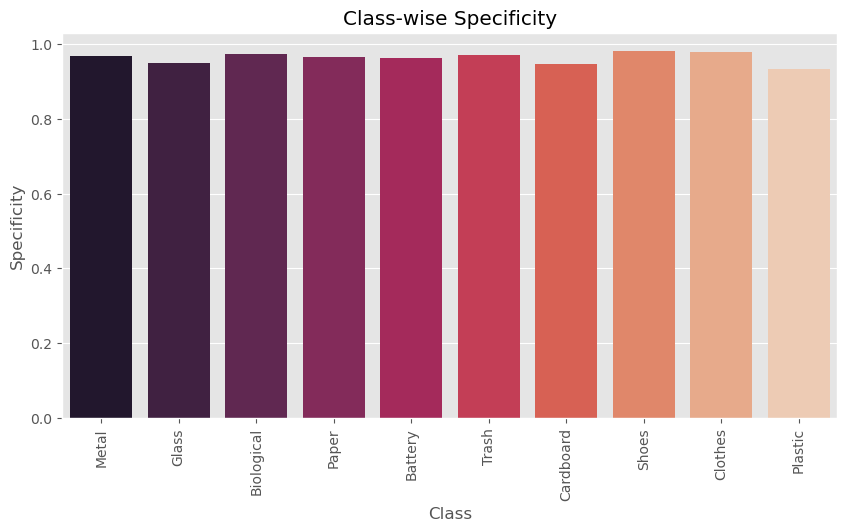

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
class_labels = ['Metal', 'Glass', 'Biological', 'Paper', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate specificity for each class
specificity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Plot class-wise specificity with a different color
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=specificity_per_class, palette='rocket')
plt.title('Class-wise Specificity')
plt.ylabel('Specificity')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate the x-axis labels

# Save the figure as a PDF
plt.savefig('classwise_specificity_plot.pdf', format='pdf')

plt.show()


138/138 [==============================] - 8s 59ms/step


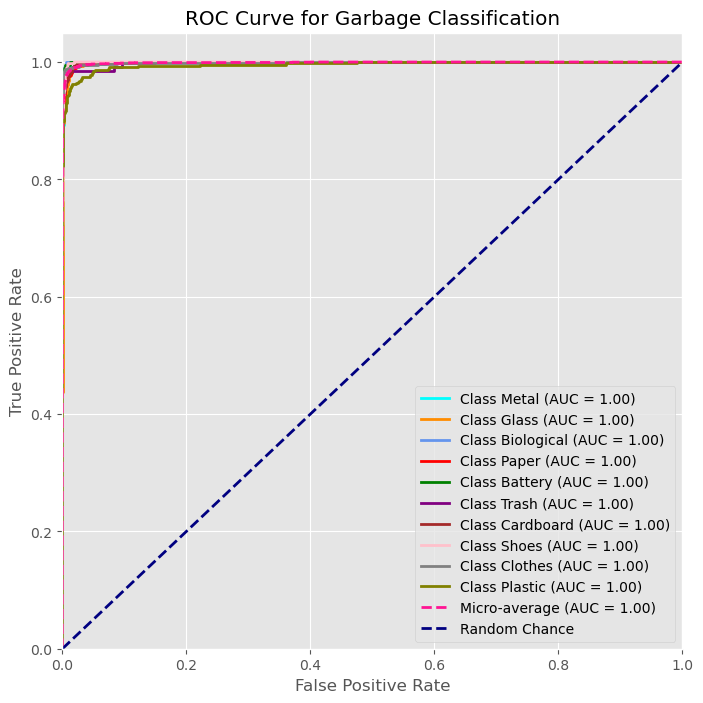

In [29]:
# Evaluate the model on the test set
y_score = model.predict(X_test)

# Binarize the true labels
y_test_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Garbage Classification')
plt.legend(loc="lower right")

# Save the figure as a PDF
plt.savefig('roc_curve_plot.pdf', format='pdf')

# Show the plot
plt.show()


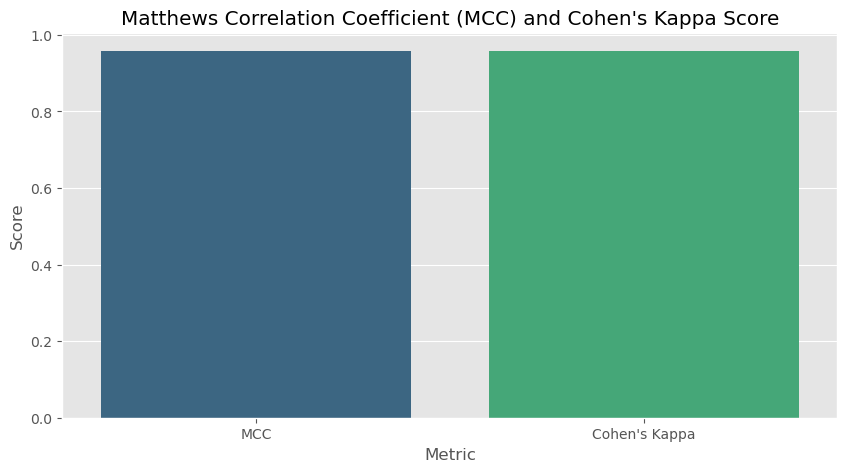

In [34]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Evaluate the model on the test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate Matthews correlation coefficient and Cohen's Kappa score
mcc = matthews_corrcoef(y_true, y_pred_classes)
kappa = cohen_kappa_score(y_true, y_pred_classes)

# Plot MCC and Kappa in the same bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=['MCC', 'Cohen\'s Kappa'], y=[mcc, kappa], palette='viridis')
plt.title('Matthews Correlation Coefficient (MCC) and Cohen\'s Kappa Score')
plt.ylabel('Score')
plt.xlabel('Metric')

# Save the figure as a PDF
plt.savefig('mcc_kappa_plot.pdf', format='pdf')

# Show the plot
plt.show()



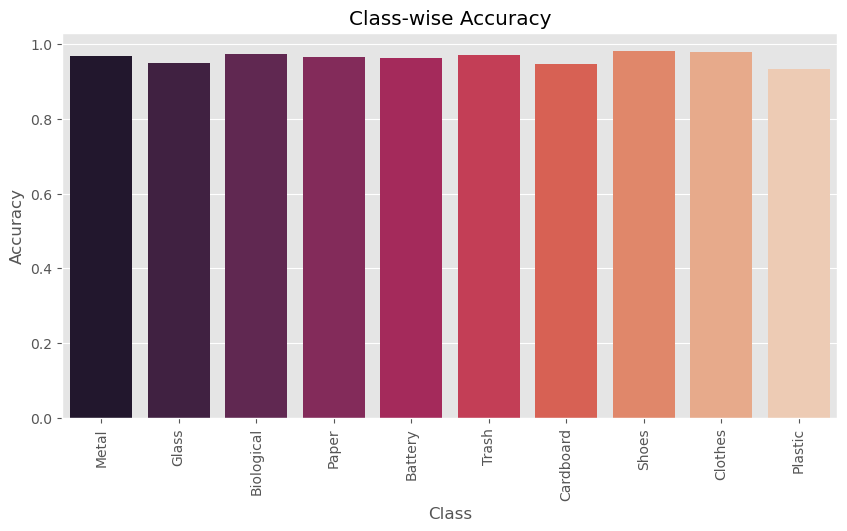

In [37]:
# Calculate accuracy for each class
accuracy_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Plot class-wise accuracy with a different color
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=accuracy_per_class, palette='rocket')
plt.title('Class-wise Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.xticks(rotation=90)  # Rotate the x-axis labels

# Save the figure as a PDF
plt.savefig('classwise_accuracy_plot.pdf', format='pdf')

plt.show()


In [38]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Evaluate the model on the test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, y_pred_classes)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Calculate Cohen's kappa score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Cohen\'s Kappa Score: {kappa:.4f}')


Matthews Correlation Coefficient (MCC): 0.9579
Cohen's Kappa Score: 0.9578


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1_score = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate specificity
overall_specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')
print(f'Overall F1 Score: {overall_f1_score:.4f}')


Overall Accuracy: 0.9636
Overall Precision: 0.9641
Overall Recall: 0.9636
Overall Specificity: 0.9636
Overall F1 Score: 0.9637
